In [5]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
#config.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=config))
from keras.optimizers import SGD
from keras.layers import Input, merge, ZeroPadding2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten

import os
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import cv2

from custom_layers.scale_layer import Scale

from subprocess import check_output



def densenet121_model(img_rows, img_cols, color_type=1, nb_dense_block=4, growth_rate=32, nb_filter=64, reduction=0.5, dropout_rate=0.0, weight_decay=1e-4, num_classes=None):
    '''
    DenseNet 121 Model for Keras

    Model Schema is based on 
    https://github.com/flyyufelix/DenseNet-Keras

    ImageNet Pretrained Weights 
    Theano: https://drive.google.com/open?id=0Byy2AcGyEVxfMlRYb3YzV210VzQ
    TensorFlow: https://drive.google.com/open?id=0Byy2AcGyEVxfSTA4SHJVOHNuTXc

    # Arguments
        nb_dense_block: number of dense blocks to add to end
        growth_rate: number of filters to add per dense block
        nb_filter: initial number of filters
        reduction: reduction factor of transition blocks.
        dropout_rate: dropout rate
        weight_decay: weight decay factor
        classes: optional number of classes to classify images
        weights_path: path to pre-trained weights
    # Returns
        A Keras model instance.
    '''
    eps = 1.1e-5

    # compute compression factor
    compression = 1.0 - reduction

    # Handle Dimension Ordering for different backends
    global concat_axis
    if K.image_dim_ordering() == 'tf':
      concat_axis = 3
      img_input = Input(shape=(img_rows, img_cols, color_type), name='data')
    else:
      concat_axis = 1
      img_input = Input(shape=(color_type, img_rows, img_cols), name='data')

    # From architecture for ImageNet (Table 1 in the paper)
    nb_filter = 64
    nb_layers = [6,12,24,16] # For DenseNet-121

    # Initial convolution
    x = ZeroPadding2D((3, 3), name='conv1_zeropadding')(img_input)
    x = Convolution2D(nb_filter, 7, 7, subsample=(2, 2), name='conv1', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv1_bn')(x)
    x = Scale(axis=concat_axis, name='conv1_scale')(x)
    x = Activation('relu', name='relu1')(x)
    x = ZeroPadding2D((1, 1), name='pool1_zeropadding')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)

    # Add dense blocks
    for block_idx in range(nb_dense_block - 1):
        stage = block_idx+2
        x, nb_filter = dense_block(x, stage, nb_layers[block_idx], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

        # Add transition_block
        x = transition_block(x, stage, nb_filter, compression=compression, dropout_rate=dropout_rate, weight_decay=weight_decay)
        nb_filter = int(nb_filter * compression)

    final_stage = stage + 1
    x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

    x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv'+str(final_stage)+'_blk_bn')(x)
    x = Scale(axis=concat_axis, name='conv'+str(final_stage)+'_blk_scale')(x)
    x = Activation('relu', name='relu'+str(final_stage)+'_blk')(x)

    x_fc = GlobalAveragePooling2D(name='pool'+str(final_stage))(x)
    x_fc = Dense(1000, name='fc6')(x_fc)
    x_fc = Activation('softmax', name='prob')(x_fc)

    model = Model(img_input, x_fc, name='densenet')

    if K.image_dim_ordering() == 'th':
      # Use pre-trained weights for Theano backend
      weights_path = 'imagenet_models/densenet121_weights_th.h5'
    else:
      # Use pre-trained weights for Tensorflow backend
      weights_path = 'imagenet_models/densenet121_weights_tf.h5'

    model.load_weights(weights_path, by_name=True)
    
    for layer in model.layers[:-2]:
        layer.trainable = False

    # Truncate and replace softmax layer for transfer learning
    # Cannot use model.layers.pop() since model is not of Sequential() type
    # The method below works since pre-trained weights are stored in layers but not in the model
    x_newfc = GlobalAveragePooling2D(name='pool'+str(final_stage))(x)
    x_newfc = Dense(num_classes, name='fc6')(x_newfc)
    x_newfc = Activation('softmax', name='prob')(x_newfc)

    model = Model(img_input, x_newfc)

    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


def conv_block(x, stage, branch, nb_filter, dropout_rate=None, weight_decay=1e-4):
    '''Apply BatchNorm, Relu, bottleneck 1x1 Conv2D, 3x3 Conv2D, and option dropout
        # Arguments
            x: input tensor 
            stage: index for dense block
            branch: layer index within each dense block
            nb_filter: number of filters
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''
    eps = 1.1e-5
    conv_name_base = 'conv' + str(stage) + '_' + str(branch)
    relu_name_base = 'relu' + str(stage) + '_' + str(branch)

    # 1x1 Convolution (Bottleneck layer)
    inter_channel = nb_filter * 4  
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x1_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_x1_scale')(x)
    x = Activation('relu', name=relu_name_base+'_x1')(x)
    x = Convolution2D(inter_channel, 1, 1, name=conv_name_base+'_x1', bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    # 3x3 Convolution
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x2_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_x2_scale')(x)
    x = Activation('relu', name=relu_name_base+'_x2')(x)
    x = ZeroPadding2D((1, 1), name=conv_name_base+'_x2_zeropadding')(x)
    x = Convolution2D(nb_filter, 3, 3, name=conv_name_base+'_x2', bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x


def transition_block(x, stage, nb_filter, compression=1.0, dropout_rate=None, weight_decay=1E-4):
    ''' Apply BatchNorm, 1x1 Convolution, averagePooling, optional compression, dropout 
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_filter: number of filters
            compression: calculated as 1 - reduction. Reduces the number of feature maps in the transition block.
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''

    eps = 1.1e-5
    conv_name_base = 'conv' + str(stage) + '_blk'
    relu_name_base = 'relu' + str(stage) + '_blk'
    pool_name_base = 'pool' + str(stage) 

    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_scale')(x)
    x = Activation('relu', name=relu_name_base)(x)
    x = Convolution2D(int(nb_filter * compression), 1, 1, name=conv_name_base, bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    x = AveragePooling2D((2, 2), strides=(2, 2), name=pool_name_base)(x)

    return x


def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None, weight_decay=1e-4, grow_nb_filters=True):
    ''' Build a dense_block where the output of each conv_block is fed to subsequent ones
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_layers: the number of layers of conv_block to append to the model.
            nb_filter: number of filters
            growth_rate: growth rate
            dropout_rate: dropout rate
            weight_decay: weight decay factor
            grow_nb_filters: flag to decide to allow number of filters to grow
    '''

    eps = 1.1e-5
    concat_feat = x

    for i in range(nb_layers):
        branch = i+1
        x = conv_block(concat_feat, stage, branch, growth_rate, dropout_rate, weight_decay)
        concat_feat = merge([concat_feat, x], mode='concat', concat_axis=concat_axis, name='concat_'+str(stage)+'_'+str(branch))

        if grow_nb_filters:
            nb_filter += growth_rate

    return concat_feat, nb_filter

if __name__ == '__main__':

    # Example to fine-tune on 3000 samples from Cifar10

    img_rows, img_cols = 224, 224 # Resolution of inputs
    channel = 3
    num_classes = 120
    batch_size = 8 
    nb_epoch = 250
    
    directory_path = "/home/aydin/storage/aydin/kaggle-dog/Kaggle-dog-breeds-classification/cnn_finetune-master/"

    print(check_output(["ls", directory_path]).decode("utf8"))

    df_train = pd.read_csv(directory_path+'labels.csv')
    df_test = pd.read_csv(directory_path+'sample_submission.csv')

    targets_series = pd.Series(df_train['breed'])
    one_hot = pd.get_dummies(targets_series, sparse = True)

    one_hot_labels = np.asarray(one_hot)

    im_size = 224
    x_train = []
    y_train = []
    x_test = []

    i = 0 
    for f, breed in tqdm(df_train.values):
        img = cv2.imread(directory_path+'train/{}.jpg'.format(f))
        label = one_hot_labels[i]
        x_train.append(cv2.resize(img, (im_size, im_size)))
        y_train.append(label)
        i += 1


    for f in tqdm(df_test['id'].values):
        img = cv2.imread(directory_path+'test/{}.jpg'.format(f))
        x_test.append(cv2.resize(img, (im_size, im_size)))

    y_train_raw = np.array(y_train, np.uint8)
    x_train_raw = np.array(x_train, np.float32) / 255.
    x_test  = np.array(x_test, np.float32) / 255.

    print(x_train_raw.shape)
    print(y_train_raw.shape)
    print(x_test.shape)

    num_class = y_train_raw.shape[1]

    X_train, X_valid, Y_train, Y_valid = train_test_split(x_train_raw, y_train_raw, test_size=0.3, random_state=1)
    
   
    

    # Load Cifar10 data. Please implement your own load_data() module for your own dataset
   # X_train, Y_train, X_valid, Y_valid = load_cifar10_data(img_rows, img_cols)

    # Load our model
    model = densenet121_model(img_rows=img_rows, img_cols=img_cols, color_type=channel, num_classes=num_classes)

    # Start Fine-tuning
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              shuffle=True,
              verbose=1,
              validation_data=(X_valid, Y_valid),
              )

    # Make predictions
    predictions_valid = model.predict(X_valid, batch_size=batch_size, verbose=1)

    # Cross-entropy loss score
    score = log_loss(Y_valid, predictions_valid)

INCEPTION_v3_starter.ipynb
LICENSE
README.md
Untitled.ipynb
VGG19.ipynb
custom_layers
data_gen
dens121.ipynb
dense169.ipynb
densenet121.py
densenet161.py
densenet169.py
denset201.ipynb
googlenet.ipynb
googlenet.py
imagenet_models
inception v3.ipynb
inception_v3.py
inception_v4.py
inception_version4.ipynb
keras_VGG19_without pretrain.ipynb
labels.csv
load_cifar10.py
load_cifar10.pyc
mixed.ipynb
resnet101.ipynb
resnet50.ipynb
resnet_101.py
resnet_152.py
resnet_50.py
result-2.csv
result-3.csv
result-4.csv
sample_submission.csv
test
train
untitled
vgg16.py
vgg19.py
view



100%|██████████| 10357/10357 [01:37<00:00, 106.24it/s]


(10222, 224, 224, 3)
(10222, 120)
(10357, 224, 224, 3)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:80: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (7, 7), strides=(2, 2), use_bias=False, name="conv1")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:156: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), use_bias=False, name="conv2_1_x1")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:166: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), use_bias=False, name="conv2_1_x2")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:222: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:156: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), use_bias=False, name="conv2_2_x1")`
/usr/local/lib/python2.7/dist-package

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:166: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), use_bias=False, name="conv4_3_x2")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:156: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), use_bias=False, name="conv4_4_x1")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:166: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), use_bias=False, name="conv4_4_x2")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:156: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), use_bias=False, name="conv4_5_x1")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:166: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), use_bias=False, name="conv4_5_x2")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:156: UserWarning: Update your `C

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:156: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), use_bias=False, name="conv5_2_x1")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:166: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), use_bias=False, name="conv5_2_x2")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:156: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), use_bias=False, name="conv5_3_x1")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:166: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), use_bias=False, name="conv5_3_x2")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:156: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), use_bias=False, name="conv5_4_x1")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:166: UserWarning: Update your `

Train on 7155 samples, validate on 3067 samples
Epoch 1/250
7155/7155 [==============================] - 366s 51ms/step - loss: 3.4751 - acc: 0.2556 - val_loss: 1.9368 - val_acc: 0.5660
Epoch 2/250
7155/7155 [==============================] - 305s 43ms/step - loss: 1.8582 - acc: 0.5795 - val_loss: 1.2345 - val_acc: 0.6841
Epoch 3/250
7155/7155 [==============================] - 305s 43ms/step - loss: 1.3729 - acc: 0.6728 - val_loss: 1.0215 - val_acc: 0.7258
Epoch 4/250
7155/7155 [==============================] - 305s 43ms/step - loss: 1.1439 - acc: 0.7189 - val_loss: 0.9059 - val_acc: 0.7532
Epoch 5/250
7155/7155 [==============================] - 305s 43ms/step - loss: 1.0155 - acc: 0.7396 - val_loss: 0.8550 - val_acc: 0.7568
Epoch 6/250
7155/7155 [==============================] - 305s 43ms/step - loss: 0.9264 - acc: 0.7642 - val_loss: 0.8280 - val_acc: 0.7590
Epoch 7/250
7155/7155 [==============================] - 305s 43ms/step - loss: 0.8532 - acc: 0.7795 - val_loss: 0.8134 - va

7155/7155 [==============================] - 304s 43ms/step - loss: 0.2949 - acc: 0.9210 - val_loss: 0.8124 - val_acc: 0.7731
Epoch 60/250
7155/7155 [==============================] - 305s 43ms/step - loss: 0.2956 - acc: 0.9184 - val_loss: 0.8087 - val_acc: 0.7721
Epoch 61/250
7155/7155 [==============================] - 304s 43ms/step - loss: 0.2925 - acc: 0.9233 - val_loss: 0.8166 - val_acc: 0.7698
Epoch 62/250
7155/7155 [==============================] - 305s 43ms/step - loss: 0.2790 - acc: 0.9252 - val_loss: 0.8146 - val_acc: 0.7669
Epoch 63/250
7155/7155 [==============================] - 305s 43ms/step - loss: 0.2782 - acc: 0.9277 - val_loss: 0.8213 - val_acc: 0.7688
Epoch 64/250
7155/7155 [==============================] - 304s 43ms/step - loss: 0.2721 - acc: 0.9287 - val_loss: 0.8138 - val_acc: 0.7731
Epoch 65/250
7155/7155 [==============================] - 304s 43ms/step - loss: 0.2732 - acc: 0.9291 - val_loss: 0.8250 - val_acc: 0.7727
Epoch 66/250
7155/7155 [================

Epoch 118/250
7155/7155 [==============================] - 206s 29ms/step - loss: 0.2099 - acc: 0.9447 - val_loss: 0.8771 - val_acc: 0.7662
Epoch 119/250
7155/7155 [==============================] - 206s 29ms/step - loss: 0.1930 - acc: 0.9508 - val_loss: 0.8793 - val_acc: 0.7656
Epoch 120/250
7155/7155 [==============================] - 206s 29ms/step - loss: 0.2090 - acc: 0.9438 - val_loss: 0.8846 - val_acc: 0.7652
Epoch 121/250
7155/7155 [==============================] - 206s 29ms/step - loss: 0.1950 - acc: 0.9525 - val_loss: 0.8816 - val_acc: 0.7659
Epoch 122/250
7155/7155 [==============================] - 206s 29ms/step - loss: 0.1936 - acc: 0.9530 - val_loss: 0.8872 - val_acc: 0.7649
Epoch 123/250
7155/7155 [==============================] - 206s 29ms/step - loss: 0.2058 - acc: 0.9463 - val_loss: 0.8817 - val_acc: 0.7652
Epoch 124/250
7155/7155 [==============================] - 206s 29ms/step - loss: 0.1940 - acc: 0.9525 - val_loss: 0.8840 - val_acc: 0.7633
Epoch 125/250
7155/7

7155/7155 [==============================] - 207s 29ms/step - loss: 0.1619 - acc: 0.9600 - val_loss: 0.9272 - val_acc: 0.7597
Epoch 177/250
7155/7155 [==============================] - 207s 29ms/step - loss: 0.1678 - acc: 0.9563 - val_loss: 0.9330 - val_acc: 0.7623
Epoch 178/250
7155/7155 [==============================] - 207s 29ms/step - loss: 0.1546 - acc: 0.9635 - val_loss: 0.9400 - val_acc: 0.7604
Epoch 179/250
7155/7155 [==============================] - 184s 26ms/step - loss: 0.1569 - acc: 0.9597 - val_loss: 0.9367 - val_acc: 0.7613
Epoch 180/250
7155/7155 [==============================] - 186s 26ms/step - loss: 0.1565 - acc: 0.9597 - val_loss: 0.9355 - val_acc: 0.7626
Epoch 181/250
7155/7155 [==============================] - 207s 29ms/step - loss: 0.1620 - acc: 0.9586 - val_loss: 0.9472 - val_acc: 0.7610
Epoch 182/250
7155/7155 [==============================] - 207s 29ms/step - loss: 0.1549 - acc: 0.9600 - val_loss: 0.9454 - val_acc: 0.7577
Epoch 183/250
7155/7155 [=========

7155/7155 [==============================] - 208s 29ms/step - loss: 0.1478 - acc: 0.9611 - val_loss: 0.9891 - val_acc: 0.7584
Epoch 235/250
7155/7155 [==============================] - 208s 29ms/step - loss: 0.1431 - acc: 0.9649 - val_loss: 0.9809 - val_acc: 0.7574
Epoch 236/250
7155/7155 [==============================] - 208s 29ms/step - loss: 0.1404 - acc: 0.9637 - val_loss: 0.9844 - val_acc: 0.7574
Epoch 237/250
7155/7155 [==============================] - 208s 29ms/step - loss: 0.1339 - acc: 0.9670 - val_loss: 0.9768 - val_acc: 0.7584
Epoch 238/250
7155/7155 [==============================] - 208s 29ms/step - loss: 0.1548 - acc: 0.9574 - val_loss: 0.9900 - val_acc: 0.7561
Epoch 239/250
7155/7155 [==============================] - 208s 29ms/step - loss: 0.1399 - acc: 0.9637 - val_loss: 0.9762 - val_acc: 0.7594
Epoch 240/250
7155/7155 [==============================] - 208s 29ms/step - loss: 0.1448 - acc: 0.9632 - val_loss: 0.9815 - val_acc: 0.7564
Epoch 241/250
7155/7155 [=========

In [ ]:
preds = model.predict(x_test, verbose=1)

sub = pd.DataFrame(preds)
# Set column names to those generated by the one-hot encoding earlier
col_names = one_hot.columns.values
sub.columns = col_names
# Insert the column id from the sample_submission at the start of the data frame
sub.insert(0, 'id', df_test['id'])
sub.head(5)

sub.to_csv(directory_path+"result-5.csv", encoding='utf-8', index=False)


In [36]:
preds = model.predict(x_test, verbose=1)

sub = pd.DataFrame(preds)
# Set column names to those generated by the one-hot encoding earlier
col_names = one_hot.columns.values
sub.columns = col_names
# Insert the column id from the sample_submission at the start of the data frame
sub.insert(0, 'id', df_test['id'])
sub.head(5)

sub.to_csv(directory_path+"result-4.csv", encoding='utf-8', index=False)


10357/10357 [==============================] - 225s 22ms/step


In [4]:
ls ..

Kaggle-dog-breeds-classification/  sample_submission.csv      train/
labels.csv                         sample_submission.csv.zip  train.zip
labels.csv.zip                     test/
result-2.csv                       test.zip


In [6]:
import numpy as np

original_train_dir = '/storage/aydin/kaggle-dog/Kaggle-dog-breeds-classification/cnn_finetune-master/train'
original_test_dir = '/storage/aydin/kaggle-dog/Kaggle-dog-breeds-classification/cnn_finetune-master/test'
train_labels = np.loadtxt('/storage/aydin/kaggle-dog/Kaggle-dog-breeds-classification/cnn_finetune-master/labels.csv', delimiter=',', dtype=str, skiprows=1)
# Remove missing data, this image was missing on my dataset?
# train_labels = train_labels[train_labels[:, 0] != '000bec180eb18c7604dcecc8fe0dba07']
clazzes, counts = np.unique(train_labels[:, 1], return_counts=True)
print("Some classes with count:")
print(np.asarray((clazzes, counts)).T[0:10])
print("Number of class: %d" % clazzes.size)


Some classes with count:
[['affenpinscher' '80']
 ['afghan_hound' '116']
 ['african_hunting_dog' '86']
 ['airedale' '107']
 ['american_staffordshire_terrier' '74']
 ['appenzeller' '78']
 ['australian_terrier' '102']
 ['basenji' '110']
 ['basset' '82']
 ['beagle' '105']]
Number of class: 120


In [10]:
import os, shutil

def mkdirIfNotExist(directory):
    if not os.path.exists(directory):
        os.mkdir(directory)
    return directory

base_dir = mkdirIfNotExist('./data_gen')
train_dir = mkdirIfNotExist(os.path.join(base_dir, 'train'))
validation_dir = mkdirIfNotExist(os.path.join(base_dir, 'validation'))
test_dir = mkdirIfNotExist(os.path.join(base_dir, 'test'))
for clazz in clazzes[:]:
    mkdirIfNotExist(os.path.join(train_dir, clazz))
    mkdirIfNotExist(os.path.join(validation_dir, clazz))


In [11]:
def copyIfNotExist(fnames, src_dir, dst_dir):
    nCopied = 0
    for fname in fnames:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(dst_dir, fname)
        if not os.path.exists(dst):
            shutil.copyfile(src, dst)
            nCopied += 1
    if nCopied > 0:
        print("Copied %d to %s" % (nCopied, dst_dir))

# This will split available labeled data to train-validation sets
train_ratio = 0.7
for clazz in clazzes[:]:
    fnames = train_labels[train_labels[:, 1] == clazz][:,0]
    fnames = ['{}.jpg'.format(name) for name in fnames]
    idx = int(len(fnames)*(1-train_ratio))
    val_fnames = fnames[:idx]
    train_fnames = fnames[idx:]
    train_class_dir = os.path.join(train_dir, clazz)
    validation_class_dir = os.path.join(validation_dir, clazz)
    copyIfNotExist(train_fnames, original_train_dir, train_class_dir)
    copyIfNotExist(val_fnames, original_train_dir, validation_class_dir)


Copied 56 to ./data_gen/train/affenpinscher
Copied 24 to ./data_gen/validation/affenpinscher
Copied 82 to ./data_gen/train/afghan_hound
Copied 34 to ./data_gen/validation/afghan_hound
Copied 61 to ./data_gen/train/african_hunting_dog
Copied 25 to ./data_gen/validation/african_hunting_dog
Copied 75 to ./data_gen/train/airedale
Copied 32 to ./data_gen/validation/airedale
Copied 52 to ./data_gen/train/american_staffordshire_terrier
Copied 22 to ./data_gen/validation/american_staffordshire_terrier
Copied 55 to ./data_gen/train/appenzeller
Copied 23 to ./data_gen/validation/appenzeller
Copied 72 to ./data_gen/train/australian_terrier
Copied 30 to ./data_gen/validation/australian_terrier
Copied 77 to ./data_gen/train/basenji
Copied 33 to ./data_gen/validation/basenji
Copied 58 to ./data_gen/train/basset
Copied 24 to ./data_gen/validation/basset
Copied 74 to ./data_gen/train/beagle
Copied 31 to ./data_gen/validation/beagle
Copied 63 to ./data_gen/train/bedlington_terrier
Copied 26 to ./data_g

Copied 51 to ./data_gen/train/redbone
Copied 21 to ./data_gen/validation/redbone
Copied 62 to ./data_gen/train/rhodesian_ridgeback
Copied 26 to ./data_gen/validation/rhodesian_ridgeback
Copied 54 to ./data_gen/train/rottweiler
Copied 22 to ./data_gen/validation/rottweiler
Copied 59 to ./data_gen/train/saint_bernard
Copied 25 to ./data_gen/validation/saint_bernard
Copied 70 to ./data_gen/train/saluki
Copied 29 to ./data_gen/validation/saluki
Copied 77 to ./data_gen/train/samoyed
Copied 32 to ./data_gen/validation/samoyed
Copied 61 to ./data_gen/train/schipperke
Copied 25 to ./data_gen/validation/schipperke
Copied 58 to ./data_gen/train/scotch_terrier
Copied 24 to ./data_gen/validation/scotch_terrier
Copied 89 to ./data_gen/train/scottish_deerhound
Copied 37 to ./data_gen/validation/scottish_deerhound
Copied 62 to ./data_gen/train/sealyham_terrier
Copied 26 to ./data_gen/validation/sealyham_terrier
Copied 54 to ./data_gen/train/shetland_sheepdog
Copied 22 to ./data_gen/validation/shetlan

In [12]:
from keras.preprocessing.image import ImageDataGenerator
img_width ,img_height = 299, 299
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.1,
    zoom_range=0.1
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical')
total_train_image_count = train_generator.samples
class_count = train_generator.num_class

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
total_val_image_count = train_generator.samples


Using TensorFlow backend.


Found 7213 images belonging to 120 classes.


AttributeError: 'DirectoryIterator' object has no attribute 'num_class'

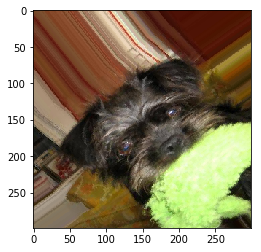

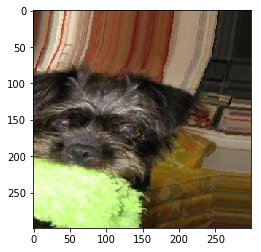

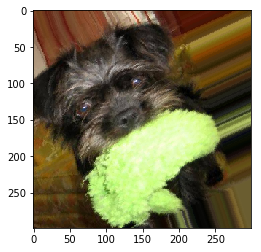

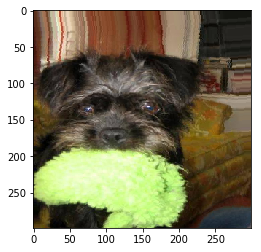

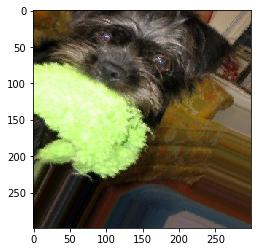

In [25]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

train_first_dir = os.path.join(train_dir, clazzes[0])
fnames = [os.path.join(train_first_dir, fname) for fname in os.listdir(train_first_dir)]

img_path = fnames[3]
img = image.load_img(img_path, target_size=(img_width, img_height))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 5 == 0:
        break

plt.show()

In [33]:
from keras.optimizers import SGD
from keras.layers import Input, merge, ZeroPadding2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten

import os
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import cv2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from custom_layers.scale_layer import Scale

from subprocess import check_output

directory_path = "/home/aydin/storage/aydin/kaggle-dog/Kaggle-dog-breeds-classification/cnn_finetune-master/"

df_train = pd.read_csv(directory_path+'labels.csv')
df_test = pd.read_csv(directory_path+'sample_submission.csv')

targets_series = pd.Series(df_train['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)

one_hot_labels = np.asarray(one_hot)

im_size = 224
x_train = []
y_train = []
x_test = []
  

i = 0 
for f, breed in tqdm(df_train.values):
    img = cv2.imread(directory_path+'train/{}.jpg'.format(f))
    label = one_hot_labels[i]
    x_train.append(cv2.resize(img, (im_size, im_size)))
    y_train.append(label)
    i += 1


for f in tqdm(df_test['id'].values):
    img = cv2.imread(directory_path+'test/{}.jpg'.format(f))
    x_test.append(cv2.resize(img, (im_size, im_size)))

y_train_raw = np.array(y_train, np.uint8)
x_train_raw = np.array(x_train, np.float32) / 255.
x_test  = np.array(x_test, np.float32) / 255.

print(x_train_raw.shape)
print(y_train_raw.shape)
print(x_test.shape)

100%|██████████| 10357/10357 [09:39<00:00, 17.86it/s]


(10222, 224, 224, 3)
(10222, 120)
(10357, 224, 224, 3)


In [34]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

datagen.fit(x_train_raw)


# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                    steps_per_epoch=len(x_train) / 32, epochs=epochs)

NameError: name 'model' is not defined

In [7]:
ls storage/aydin/kaggle-dog/Kaggle-dog-breeds-classification/cnn_finetune-master

ls: cannot access 'storage/aydin/kaggle-dog/Kaggle-dog-breeds-classification/cnn_finetune-master': No such file or directory
